# **WallJump with PPO**

### **Imports**

In [162]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
### Torch RL
import torchrl as rl

# Env
from torchrl.envs import Transform
from torchrl.envs.transforms.transforms import _apply_to_composite_inv
from torchrl.envs.transforms.utils import _set_missing_tolerance
from torchrl.data.tensor_specs import Composite, Unbounded, Categorical, BoxList, OneHot
from torchrl.envs.libs import UnityMLAgentsEnv
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from torchrl.envs.utils import step_mdp, check_env_specs
from torchrl.envs import TransformedEnv, Stack, ExcludeTransform, RenameTransform

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data import LazyTensorStorage, ReplayBuffer, LazyMemmapStorage, SliceSamplerWithoutReplacement
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from tensordict import TensorDict, TensorDictBase
from torchrl.collectors.utils import split_trajectories


# Model
from model import create_policy, create_value
# Train Util
from train_util import make_loss_module, compute_trajectory_metrics, loss_dict, Stopwatch, Logger, Checkpointer, load_model
# Inspect Results
from result import plot, play, test

from config import (
    ENV_PATH, N_ENVS,
    OBSERVATION_DIM, ACTION_DIM,
    CKPT_PATH, LOG_PATH, MODEL_PATH, RESULTS_PATH,
    LOG_KEYS, LOG_INDEX, BEST_METRIC_KEY,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Env Transforms**

In [2]:
class InvertibleCatTensors(Transform):
    invertible = True

    def __init__(self, in_keys, out_key, dim, del_keys = True):
        super().__init__(in_keys=in_keys, out_keys=[out_key])
        if out_key in in_keys: raise Exception(f"out_key={out_key} cannot be in in_keys={in_keys}")
        self.in_keys = in_keys
        self.out_key = out_key
        self.dim = dim
        self._del_keys = del_keys
        self.in_key_dims = None # Set in transform_observation_spec

    def _call(self, next_tensordict):
        # Get in keys
        values = [next_tensordict.get(key, None) for key in self.in_keys]
        if any(value is None for value in values):
            raise Exception(
                f"InvertibleCatTensor failed, as it expected input keys ="
                f" {self.in_keys} but got a TensorDict with keys"
                f" {next_tensordict.keys(include_nested=True)}"
            )

        # Concat them
        out_tensor = torch.cat(values, dim=self.dim)
        next_tensordict.set(self.out_keys[0], out_tensor)
        if self._del_keys:
            next_tensordict.exclude(*self.in_keys, inplace=True)
        return next_tensordict

    forward = _call

    def _reset(self, tensordict, tensordict_reset):
        with _set_missing_tolerance(self, True):
            tensordict_reset = self._call(tensordict_reset)
        return tensordict_reset
    
    def _inv_call(self, in_tensordict):
        cat = in_tensordict[self.out_keys[0]]
        index = 0

        # Set in keys (unconcat) if they were deleted
        if self._del_keys:
            for key, dim in zip(self.in_keys, self.in_key_dims):
                idx = torch.arange(index, index + dim)
                in_tensordict[key] = torch.index_select(cat, self.dim, idx)
                index += dim
        # Delete out key (concat)
        in_tensordict.exclude(self.out_keys[0], inplace=True)

        return in_tensordict

    def transform_observation_spec(self, observation_spec):
        # check that all keys are in observation_spec
        if len(self.in_keys) > 1 and not isinstance(observation_spec, Composite):
            raise ValueError(
                "CatTensor cannot infer the output observation spec as there are multiple input keys but "
                "only one observation_spec."
            )

        if isinstance(observation_spec, Composite) and len(
            [key for key in self.in_keys if key not in observation_spec.keys(True)]
        ):
            raise ValueError(
                "CatTensor got a list of keys that does not match the keys in observation_spec. "
                "Make sure the environment has an observation_spec attribute that includes all the specs needed for CatTensor."
            )

        if not isinstance(observation_spec, Composite):
            # by def, there must be only one key
            return observation_spec

        # Input keys
        keys = self.in_keys
        # Save dimensions for inverse
        self.in_key_dims = [
            observation_spec[key].shape[self.dim]
            if observation_spec[key].shape
            else 1
            for key in keys
        ]
        # Concat length
        sum_shape = sum(self.in_key_dims)

        # Set new spec
        spec0 = observation_spec[keys[0]]
        out_key = self.out_keys[0]
        shape = list(spec0.shape)
        device = spec0.device
        shape[self.dim] = sum_shape
        shape = torch.Size(shape)
        observation_spec[out_key] = Unbounded(
            shape=shape,
            dtype=spec0.dtype,
            device=device,
        )
        # Delete old
        if self._del_keys:
            for key in self.in_keys:
                if key in observation_spec.keys(True):
                    del observation_spec[key]
        return observation_spec

In [3]:
class SetBatchDim(Transform):
    # Only works on a environment without batch size
    invertible = True
    
    def __init__(self, batch_size):
        super().__init__()
        self._batch_size = batch_size

    def _call(self, next_tensordict):
        next_tensordict.batch_size = self._batch_size
        return next_tensordict

    forward = _call

    def _reset(self, tensordict, tensordict_reset):
        with _set_missing_tolerance(self, True):
            tensordict_reset = self._call(tensordict_reset)
        return tensordict_reset
    
    def _inv_call(self, in_tensordict):
        in_tensordict.batch_size = torch.Size([])
        return in_tensordict

    def transform_env_batch_size(self, batch_size):
        return self._batch_size
    
    def transform_observation_spec(self, observation_spec):
        observation_spec.shape = self._batch_size
        return observation_spec
    
    def transform_reward_spec(self, reward_spec):
        reward_spec.shape = self._batch_size
        return reward_spec
    
    def transform_done_spec(self, done_spec):
        done_spec.shape = self._batch_size
        return done_spec
    
    def transform_action_spec(self, action_spec):
        action_spec.shape = self._batch_size
        return action_spec

In [4]:
class RenameAction(Transform):
    invertible=True
    def __init__(self, prev_key, new_key):
        super().__init__(in_keys_inv=[new_key], out_keys_inv=[prev_key])
        self.prev_key = prev_key
        self.new_key = new_key

    def _inv_call(self, in_tensordict):
        in_tensordict.rename_key_(self.new_key, self.prev_key)
        return in_tensordict

    def transform_action_spec(self, action_spec):
        action_spec[self.new_key] = action_spec[self.prev_key]
        del action_spec[self.prev_key]
        return action_spec

In [5]:
class FlattenMultiOneHot(Transform):
    def __init__(self, action_key):
        super().__init__(in_keys_inv=[action_key], out_keys_inv=[action_key])
        self._initialized = False

    def _inv_call(self, tensordict):
        if not self._initialized: self._set_dims()

        # Get One Hot Actions
        action_key = self.parent.action_key
        action_data = tensordict[action_key]

        # Convert to Categorical (get index)
        index = torch.argmax(action_data, dim=-1, keepdims=True)

        # Unravel to each mini category index, D x [B, 1]
        multi_cat = torch.unravel_index(index, self._dims)

        # Set each mini category one hot vector, [B, C], C=sum(C_i)
        multi_one_hot = []
        for cat, dim in zip(multi_cat, self._dims):
            # [B, C_i]
            one_hot = F.one_hot(cat.squeeze(-1), num_classes=dim)
            multi_one_hot.append(one_hot)

        tensordict[action_key] = torch.cat(multi_one_hot, dim=-1)
        return tensordict

    def _set_dims(self):
        self._dims = [box.n for box in self.parent.action_spec[self.in_keys_inv[0]].space.boxes]
        self._dim_sum = sum(self._dims)
        self._initialized = True
    
    @_apply_to_composite_inv
    def transform_input_spec(self, action_spec):
        # Passthrough if already flat (or not the right key)
        if not isinstance(action_spec.space, BoxList): return action_spec

        # Get dims
        if not self._initialized: self._set_dims()
        n = 1
        for dim in self._dims: n *= dim

        # Set dims
        shape = list(action_spec.shape)
        shape[-1] = n
        action_spec = OneHot(n, shape=torch.Size(shape), device=action_spec.device, dtype=torch.int64)
        
        return action_spec

In [6]:
class UnnestTransform(Transform):
    def __init__(self, nested_key, out_keys):
        self.nested_key = nested_key
        self.out_keys = out_keys
        self.in_keys = [(nested_key, key) for key in out_keys]
        super().__init__(in_keys=self.in_keys, out_keys=out_keys, in_keys_inv=out_keys, out_keys_inv=self.in_keys)        

    def _call(self, tensordict):
        for in_key, out_key in zip(self.in_keys, self.out_keys):
            if in_key in tensordict.keys(True):
                tensordict.rename_key_(in_key, out_key)
        if self.nested_key in tensordict.keys(True):
            tensordict.exclude(self.nested_key, inplace=True)
        return tensordict
    
    forward = _call

    def _reset(self, tensordict, tensordict_reset):
        with _set_missing_tolerance(self, True):
            tensordict_reset = self._call(tensordict_reset)
        return tensordict_reset

    def _inv_call(self, tensordict):
        for in_key, out_key in zip(self.in_keys, self.out_keys):
            if out_key in tensordict.keys(True):
                tensordict.rename_key_(out_key, in_key)
        return tensordict
    

    def _transform_spec(self, spec):
        for in_key, out_key in zip(self.in_keys, self.out_keys):
            if in_key in spec.keys(True):
                spec[out_key] = spec[in_key]
                del spec[in_key]
        if self.nested_key in spec.keys(True):
            del spec[self.nested_key]
        return spec

    transform_observation_spec = _transform_spec
    transform_action_spec = _transform_spec
    transform_reward_spec = _transform_spec
    transform_done_spec = _transform_spec

## **Create Torch Env**

In [7]:
# Unity autoresets, individual agent resets don't work, they restart the environment, make agent resets no ops
class SoftResetUnityEnv(UnityMLAgentsEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._last = None

    def _step(self, tensordict):
        self._last = tensordict
        return super()._step(tensordict)

    def _reset(self, tensordict=None, **kwargs):
        # Real Unity reset (only first reset)
        if self._last is None:
            td = super()._reset(tensordict, **kwargs)
            self._last = td
            return td

        # Soft Reset: Unity Autoresets
        return self._make_td_out(self._last, is_reset=True)

In [8]:
def _create_env(graphics, **kwargs):
        from mlagents_envs import environment # Force load for multiproccessing
        env = SoftResetUnityEnv(
            file_name=ENV_PATH, worker_id=np.random.randint(10000), 
            no_graphics=(not graphics), **kwargs,
            device="cpu",
        )
        return env

def create_unity_env(graphics=False, **kwargs):
    try: env.close()
    except: pass    
    
    # Gambling
    ATTEMPTS = 3
    for i in range(ATTEMPTS):
        try:
            env = _create_env(graphics, **kwargs)
            break
        except: pass
        if i + 1 == ATTEMPTS: raise RuntimeError("Failed to load environment")

    return env


def batch_agents(env, out_key="agents"):
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    
    # Create transform
    stack = Stack(
        in_keys=[(agent_root_key, agent) for agent in agents], 
        out_key=(out_key,), 
        in_key_inv=(out_key,), 
        out_keys_inv=[(agent_root_key, agent) for agent in agents]
    )
    batch = SetBatchDim(
        batch_size=torch.Size([len(agents)])
    )

    env.append_transform(stack).append_transform(batch)
    return env

def create_base_env(graphics=False, **kwargs):
    env = create_unity_env(graphics, **kwargs)

    # Batch into Agents Dimension
    env = batch_agents(TransformedEnv(env))    

    # Concatenate Observation
    obs_keys = env.observation_keys
    env.append_transform(
        InvertibleCatTensors(in_keys=obs_keys, out_key=("agents", "observation"), dim=-1, del_keys=True)
    )
    env.append_transform(
        ExcludeTransform(("agents", "group_reward")),
    )
    env.append_transform(
        RenameAction(env.action_key, ("agents", "action"))
    )
    env.append_transform(
        FlattenMultiOneHot(("agents", "action"))
    ).append_transform(
        UnnestTransform("agents", ["observation", "done", "terminated", "truncated", "reward", "action"])
    )

    return env

def create_env(graphics=False, time_scale = 1, **kwargs):
    # Time scale
    if time_scale != 1:
        engine_config_channel = EngineConfigurationChannel()
        env = create_base_env(graphics, **kwargs, side_channels=[engine_config_channel])
        engine_config_channel.set_configuration_parameters(time_scale=time_scale)
    else:
        env = create_base_env(graphics, **kwargs)

    return env

### **Inspect Specs**

In [9]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_env(time_scale=20, graphics=False)
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'action' is unaccounted for by the transform (expected keys ['observation', 'done', 'terminated', 'truncated', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [10]:
td = env.rollout(10, break_when_any_done=False)
td

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        action: Tensor(shape=torch.Size([24, 10, 54]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([24, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([24, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([24, 10, 444]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([24, 10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([24, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([24, 10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([24, 10]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([24, 10, 44

### **Inspect Action Space**

We have categorical actions: 54 choices (choose one).

In [11]:
actions_df = pd.DataFrame({
    "action": td["action"].reshape(-1)
})
actions_df.describe()

,action
count,12960.000000
mean,0.018519
std,0.134822
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


### **Inspect Observation Space**

Observations consist of binary features and continuous features scaled to the range [0, 1].

In [12]:
obs_df = pd.DataFrame({
    "obs": td["observation"].reshape(-1)
})
obs_df.describe()

,obs
count,106560.000000
mean,0.328407
std,0.474978
min,-0.535648
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### **Inspect Reward Space**
-1 for jumping off, -0.0025 for surviving, +1 on success. And other values??

In [13]:
reward_df = pd.DataFrame({
    "reward": td["next", "reward"].reshape(-1),
})
reward_df.describe()

,reward
count,240.000000
mean,-0.018144
std,0.128100
min,-1.000000
25%,-0.002500
50%,-0.002500
75%,0.000000
max,0.000000


In [14]:
reward_df.value_counts()

reward 
-0.0025    140
 0.0000     92
-1.0000      4
-0.0015      2
-0.0010      1
-0.0005      1
Name: count, dtype: int64

## **Create Models**

### **Config**

In [15]:
HIDDEN_DIM = 256
N_BLOCKS = 3

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": OBSERVATION_DIM,
    "out_features": ACTION_DIM,
}
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 3, 'in_features': 444, 'out_features': 54}

### **Inspect**

In [16]:
try: env.close()
except: pass
env = create_env()

policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

data = None
with torch.no_grad():
    data = env.rollout(20, policy=policy, auto_cast_to_device=True, break_when_any_done=False).to(device)
    env.close()
    loss_module.value_estimator(data)
data

Thread 0x16ee7f000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16d853000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [2.0 KB-4.0 KB]: 2 frames, [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 84.8 KB
      Overflow Count 6
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 11]
      Initial Block 

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'action' is unaccounted for by the transform (expected keys ['observation', 'done', 'terminated', 'truncated', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


Thread 0x16ee5f000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16d94b000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [0-1.0 KB]: 9600 frames, [2.0 KB-4.0 KB]: 75 frames, [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 84.8 KB
      Overflow Count 6
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worke

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([24, 20, 54]), device=cpu, dtype=torch.int64, is_shared=False),
        advantage: Tensor(shape=torch.Size([24, 20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([24, 20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        log_prob: Tensor(shape=torch.Size([24, 20]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([24, 20, 54]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([24, 20, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([24, 20, 444]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([24, 20, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                state_value: Tensor(shape=torch.Size([24, 20, 1])

In [17]:
traj_data = split_trajectories(data)
compute_trajectory_metrics(traj_data)

{'return': -0.2544354796409607,
 'episode_length': 15.483870506286621,
 'entropy': 3.8024067878723145}

## **Training**

### **Train Config**

In [166]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

### Training Loop Params
WORKERS = os.cpu_count() // 2
STORAGE_DEVICE = "cpu"
GENERATION_SIZE = 200 * N_ENVS * WORKERS
COLLECTOR_BUFFER_SIZE = 10_000
TIMESTAMPS = GENERATION_SIZE * 500
EPOCHS = 5

# GD Params
MINIBATCH_SIZE = 1024
ADV_MINIBATCH_SIZE = (10_000 // (WORKERS * N_ENVS)) * WORKERS * N_ENVS
LR = 5e-5
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params
TIME_SCALE = 20

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-4

NAME = 'run0'

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1

CONTINUE=True
print(f"generations: {TIMESTAMPS//GENERATION_SIZE} generation_size: {GENERATION_SIZE} device: {device} workers: {WORKERS}")

generations: 500 generation_size: 33600 device: cpu workers: 7


### **Train Loop**

In [167]:
def train(create_env, policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    # Replay Buffers
    collect_replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(GENERATION_SIZE, device=STORAGE_DEVICE, ndim=2 + int(WORKERS > 1)),
        sampler=SliceSamplerWithoutReplacement(
            slice_len = ADV_MINIBATCH_SIZE //  (N_ENVS * WORKERS),
            shuffle=False, strict_length=False, 
            end_key=("next", "done")
        ),
        batch_size=ADV_MINIBATCH_SIZE,
    )
    train_replay_buffer = ReplayBuffer(storage=LazyMemmapStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)

    # Collectors
    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=COLLECTOR_BUFFER_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            update_at_each_batch=True,
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=COLLECTOR_BUFFER_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
        )


    total_generations = int(np.ceil(timestamps/GENERATION_SIZE))
    collector_iters_per_gen = int(np.ceil(GENERATION_SIZE / COLLECTOR_BUFFER_SIZE))

    ### TRAINING LOOP
    for i in range(start_generation, total_generations):
        # 1. COLLECT TRAJECTORY DATASET
        policy.eval(); value.eval()
        short_watch.start(); long_watch.start()
        collect_replay_buffer.empty()

        # Buffer in memory then move to memory mapped storage in loop
        for j in range(collector_iters_per_gen):
            data = collector.next()
            collect_replay_buffer.extend(data)
        
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})


        # 2. Compute Advantages, Value Target, and Metrics (Iterate Along Trajectories)
        train_replay_buffer.empty()
        for j, batch in enumerate(collect_replay_buffer):
            batch = batch.to(device)
        
            with torch.no_grad():
                loss_module.value_estimator(batch)
                metrics = compute_trajectory_metrics(split_trajectories(batch))
            
            logger.accumulate(metrics)
            train_replay_buffer.extend(batch.reshape(-1).cpu())
        collect_replay_buffer.empty() # A bit inefficient to only delete here

        # 3. Minibatch Gradient Descent Loop (Iterate along random timesteps)
        short_watch.start()
        policy.train(); value.train()

        for epoch in range(EPOCHS):
            for j, batch in enumerate(train_replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(loss_dict(loss_data, weight))

        train_replay_buffer.empty()
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 4. Log results
        logger.sum({"generation": 1})
        logger.sum({"timestep": GENERATION_SIZE})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        
        # 5. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[BEST_METRIC_KEY]
            checkpointer.save_progress(metric_key=BEST_METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                BEST_METRIC_KEY: metric,
            })

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [ ]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

env_fn = lambda: create_env(time_scale=TIME_SCALE)

train(env_fn, policy, value, timestamps=TIMESTAMPS)

CHECKPOINT FOUND, STARTING FROM GENERATION: 492


/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/collectors/collectors.py:2137: UserWarning: total_frames (268800) is not exactly divisible by frames_per_batch (10000). This means 1200 additional frames will be collected. To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(
/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/collectors/collectors.py:2836: UserWarning: frames_per_batch 10000 is not exactly divisible by the number of collector workers 7, this results in more frames_per_batch per iteration that requested.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

## **Test**

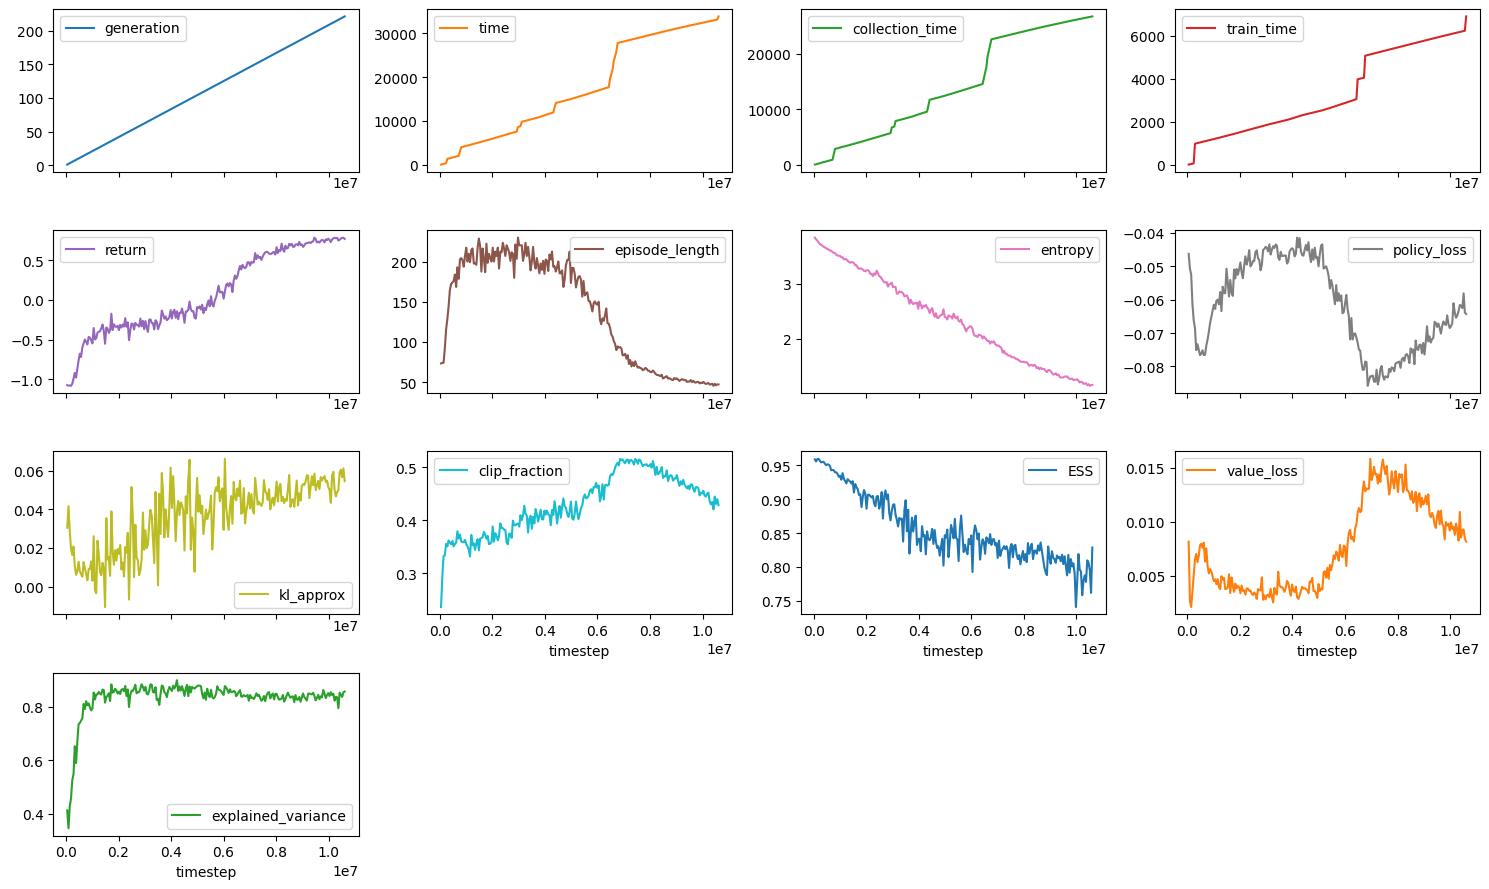

In [149]:
plot(NAME)

In [150]:
checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
checkpointer.copy_model('best', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))

In [151]:
policy = create_policy(MODEL_CONFIG).to(device)
load_model(MODEL_PATH, NAME, policy, None)

In [154]:
try: env.close()
except: pass


replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)

timestamps = 500 * N_ENVS
collector = SyncDataCollector(
    lambda: create_env(graphics=True), policy, 
    frames_per_batch=timestamps, 
    total_frames=timestamps, 
    env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
    replay_buffer=replay_buffer, exploration_type=rl.envs.utils.ExplorationType.DETERMINISTIC
)
collector.next()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'action' is unaccounted for by the transform (expected keys ['observation', 'done', 'terminated', 'truncated', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(
/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/data/replay_buffers/replay_buffers.py:742: UserWarning: Using `add()` with a TensorDict that has batch_size=torch.Size([24]). Use `extend()` to add multiple elements, or `add()` with a single element (batch_size=torch.Size([])). You can silence this warning by setting the `RL_WARNINGS` environment variable to `'0'`.
  warnings.

In [24]:
try: env.close()
except: pass